In [ ]:
# import all the necessary Libraries
import pandas as pd
import numpy as np
from PIL import Image
import PIL
import pathlib
import os
from tqdm.notebook import trange, tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [ ]:
# connect google colab to google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_dir = '/content/drive/MyDrive/Final_Project/Data'
data_dir

In [ ]:
data = pathlib.Path(data_dir) 

In [ ]:
# number of pictures in each folder
print('length of rambutan: ',len(list(data.glob('rambutan/*'))))
print('length of kaki: ', len(list(data.glob('kaki_augment/*'))))
print('length of mangosteen: ',len(list(data.glob('mangosteen/*'))))
print('length of cherimoya: ', len(list(data.glob('cherimoya_augment/*'))))
print('length of non_exotic_class: ', len(list(data.glob('non_exotic_class/*'))))

In [ ]:
# put all the images in a dictionary
fruit_images = {
    'rambutan':list(data.glob('rambutan/*')),
    'kaki':list(data.glob('kaki_augment/*')),
    'mangosteen':list(data.glob('mangosteen/*')),
    'cherimoya':list(data.glob('cherimoya_augment/*')),
    'non_exotic_class' : list(data.glob('non_exotic_class/*'))  
}

In [ ]:
# labelling the fruits
fruit_labels = {
    'rambutan':0,
    'kaki':1,
    'mangosteen' : 2,
    'cherimoya':3,
    'non_exotic_class' :4   
}

In [ ]:
# Labelling the images
x, y = [],[]
for name, images in tqdm(fruit_images.items()):
  for image in tqdm(images):
    try:
      img = load_img(str(image))
    except PIL.UnidentifiedImageError as e:
      print(f'Image is {str(image)}')
      print(e)
      break
    img= img.resize((224,224))  
    img = img_to_array(img)/255.0

    x.append(img)
    y.append(fruit_labels[name])

## preprocessing images

In [ ]:
# creating a numpy array fron the list of images 
X= np.array(x)
Y = np.array(y)


# Train test split data

In [ ]:
from sklearn.model_selection import train_test_split

# splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print('train:' , len(x_train), '        test:', len(x_test))

In [ ]:
# splitting the x_train data into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print('train:' , len(X_train), '        validation:', len(X_val))

## Build Convolutional Neural network with Data Augmentation and pre-trained model VGG16


In [ ]:
# import the necessary libraries for Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
# create a data generator
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(224, 
                                                              224,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


In [ ]:
# Pre-traind model from keras application
from tensorflow.keras.applications.vgg16 import VGG16

model_16 = VGG16(weights='imagenet', include_top=False,input_shape=(224, 224, 3), classes=5)
model_16.trainable = False

In [ ]:
# Neural network with data augmentation and pre-trained model

model = Sequential([
  data_augmentation,
  model_16,

  layers.Flatten(),
  layers.Dense(1024, activation='relu'),
  layers.Dense(512, activation = 'relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
                
history = model.fit(X_train, Y_train, epochs=50,
                    validation_data=(X_val, Y_val))   



In [ ]:
# Saving the trained model
model.save('/content/drive/MyDrive/Final_Project/Fruit_model.h5') 

In [ ]:
# loadind the saved model for further use
from keras.models import load_model
New_Fruit_model = load_model('/content/drive/MyDrive/Final_Project/Fruit_model.h5')

In [ ]:
New_Fruit_model.optimizer

18/18 - 4s - loss: 0.9227 - accuracy: 0.8380 - 4s/epoch - 219ms/step


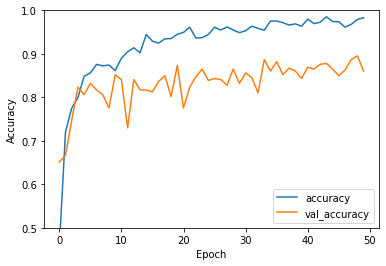

In [ ]:
# plotting the Accuracy graph of train and validation data
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
# evaluating the model to find the accuracy
model.evaluate(x_test, y_test)

In [ ]:
# predictions with x_test data
predictions = model.predict(x_test)
predictions

In [ ]:
i = 50
score = tf.nn.softmax(predictions[i])
print( 'predicted_value :', np.argmax(score),'        Real value: ', y_test[i])

predicted_value : 1         Real value:  1


In [ ]:
# get the count of false predictions

y_pred = []
count = 0
for i in range(len(x_test)):
  score = tf.nn.softmax(predictions[i])
  predicted_class = np.argmax(score)
  y_pred.append(predicted_class)
  real_class = y_test[i]
  if predicted_class == real_class:

    continue
  else: 
    count+=1
    #print('predicted_class :', np.argmax(score), '        Real Class: ', y_test[i])
count

93

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

#print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

array([[113,   1,   1,   0,  19],
       [  1,  80,   8,   0,  15],
       [  1,   0,  92,   0,  17],
       [  1,   1,   3,  71,  11],
       [  7,   1,   3,   3, 125]])